# EE511 Final Project

In this file we train the SqueezeNet model as described in the paper found [here](https://arxiv.org/abs/1602.07360).
This implementation uses the CIFAR10 dataset.

## Task 1: Train SqueezeNet

For task 1 we train SqueezeNet for 100 epochs and are able to get a final test accuracy of 80.99%.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.ao.quantization import QuantStub, DeQuantStub
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import helper

from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device={device}")

Device=cuda


## Implementation

The class in this cell below defines our architecture and defines our forward pass. We insert quantization stub for later Quantization Aware Training. We also define helper functions to save and load the model.

In [ ]:
# import math
# class Fire(nn.Module):
#     def __init__(self, inplanes, squeeze_planes, expand_planes):
#         super(Fire, self).__init__()
#         self.conv1 = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
#         self.relu1 = nn.ReLU()
#         self.conv2 = nn.Conv2d(squeeze_planes, expand_planes, kernel_size=1)
#         self.conv3 = nn.Conv2d(squeeze_planes, expand_planes, kernel_size=3, padding=1)
#         self.relu2 = nn.ReLU()

#         # # MSR initialization
#         # for m in self.modules():
#         #     if isinstance(m, nn.Conv2d):
#         #         n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
#         #         m.weight.data.normal_(0, math.sqrt(2. / n))

#     def forward(self, x):
#         x = self.relu1(self.conv1(x))
#         out1 = self.conv2(x)
#         out2 = self.conv3(x)
#         out = torch.cat([out1, out2], 1)
#         out = self.relu2(out)
#         return out

# class SqueezeNetCIFAR10(nn.Module):
#     def __init__(self, num_classes=10):
#         super(SqueezeNetCIFAR10, self).__init__()
#         # self.quant = QuantStub()
#         # self.dequant = DeQuantStub()

#         # self.upsample = nn.Upsample(size=224, mode='bilinear', align_corners=False)

#         self.conv1 = nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3)
#         self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

#         self.fire2 = Fire(96, 16, 64)
#         self.fire3 = Fire(128, 16, 64)
#         self.fire4 = Fire(128, 32, 128)
#         self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

#         self.fire5 = Fire(256, 32, 128)
#         self.fire6 = Fire(256, 48, 192)
#         self.fire7 = Fire(384, 48, 192)
#         self.fire8 = Fire(384, 64, 256)
#         self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

#         self.fire9 = Fire(512, 64, 256)
#         self.conv10 = nn.Conv2d(512, num_classes, kernel_size=1)
#         self.avg_pool = nn.AvgPool2d(13)

#     def forward(self, x):
#         # x = self.upsample(x)
#         # x = self.quant(x)
#         x = self.maxpool1(self.conv1(x))

#         x = self.fire2(x)
#         x = self.fire3(x)
#         x = self.fire4(x)
#         x = self.maxpool2(x)

#         x = self.fire5(x)
#         x = self.fire6(x)
#         x = self.fire7(x)
#         x = self.fire8(x)
#         x = self.maxpool3(x)

#         x = self.fire9(x)
#         x = self.conv10(x)
#         x = self.avg_pool(x)
#         x = torch.flatten(x, 1)
#         # x = self.dequant(x)
#         return x
    
#     def load_model(self, path='squeezenet_fp32.pth',device='cpu'):
#         state_dict = torch.load(path,map_location=device)

#         new_state_dict = OrderedDict()
#         for k, v in state_dict.items():
#             if k.startswith('module.'):
#                 k = k[len('module.'):]
#             new_state_dict[k] = v

#         self.load_state_dict(new_state_dict)
#         self.to(device)
#         self.eval()

#         print(f"Model loaded from {path}")
#         # print(self)

#     def save_model(self, path='squeezenet_fp32.pth'):
#         torch.save(self.state_dict(), path)
#         print(f"Model saved to {path}")


## Load the Dataset

In this cell we define a function to load our dataset.

In [2]:
train_loader, test_loader = helper.load_dataset(batch_size=64)

Loading the CIFAR10 dataset
Loaded train data: 50000 total samples, 782 batches
Loaded test data: 10000 total samples, 157 batches


# new try

In [3]:
import torch
class FixedPointQuantizeSTE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, total_bits=8, int_bits=4, signed=True):
        frac_bits = total_bits - int_bits
        scale = 2 ** frac_bits
        
        if signed:
            max_val = (2 ** (int_bits - 1) - 1)
            min_val = -2 ** (int_bits - 1)
        else:
            max_val = (2 ** int_bits - 1)
            min_val = 0
        
        # Quantize
        q_int = torch.clamp(torch.round(input * scale), min_val * scale, max_val * scale)
        q_out = q_int / scale
        return q_out

    @staticmethod
    def backward(ctx, grad_output):
        # STE: pass gradient through unchanged
        return grad_output, None, None, None

def fixed_point_quantize_weights_ste(weights, total_bits=8, int_bits=4):
    return FixedPointQuantizeSTE.apply(weights, total_bits, int_bits, True)

def fixed_point_quantize_activations_ste(activations, total_bits=8, int_bits=4):
    # Use unsigned for post-ReLU activations
    return FixedPointQuantizeSTE.apply(activations, total_bits, int_bits, False)

In [4]:
class Conv2dQuant(nn.Conv2d):
    def __init__(self, in_features, out_features, k, s = 1, p = 0):
        super(Conv2dQuant, self).__init__(in_features, out_features,kernel_size=k,stride=s,padding=p)
        # self.total_bit = total_bit
        # self.int_bit = int_bit

        self.s = s
        self.p = p

    def forward(self, input_):
        w_q = fixed_point_quantize_weights_ste(self.weight)
        # x = fixed_point_quantize_activations_ste(input_)
        return  nn.functional.conv2d(
            input_,
            w_q,
            bias=self.bias,
            stride=self.s,
            padding=self.p,
            dilation=self.dilation,
            groups=self.groups
        )
        # return fixed_point_quantize_activations_ste(x)

In [8]:
import torch.nn as nn

class Fire(nn.Module):
    def __init__(self, inplanes, squeeze_planes, expand_planes):
        super(Fire, self).__init__()
        self.conv1 = Conv2dQuant(inplanes, squeeze_planes, k=1)
        self.relu1 = nn.ReLU()
        self.conv2 = Conv2dQuant(squeeze_planes, expand_planes, k=1)
        self.conv3 = Conv2dQuant(squeeze_planes, expand_planes, k=3, p=1)
        self.relu2 = nn.ReLU()

    def forward(self, x, epoch=None, inference=False):
        x = self.conv1(x)
        x = self.relu1(x)
        # print(f"ReLU1 Min value: {x.min().item()}, Max value: {x.max().item()}")
        if inference or (epoch and epoch > 3):
            x = fixed_point_quantize_activations_ste(x)
            # x = fixed_point_quantize_activations_ste(x,8,7)  # Quantize once after ReLU
        
        out1 = self.conv2(x)
        out2 = self.conv3(x)
        out = torch.cat([out1, out2], 1)
        
        out = self.relu2(out)
        # print(f"ReLU2: Min value: {x.min().item()}, Max value: {x.max().item()}")
        if inference or (epoch and epoch > 3):
            out = fixed_point_quantize_activations_ste(out)
            # out = fixed_point_quantize_activations_ste(out,8,7)  # Quantize once after final ReLU
            
        return out

class SqueezeNetCIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(SqueezeNetCIFAR10, self).__init__()

        # self.conv1 = nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3)
        self.conv1 = Conv2dQuant(3, 96, k=7, s=2, p=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire2 = Fire(96, 16, 64)
        self.fire3 = Fire(128, 16, 64)
        self.fire4 = Fire(128, 32, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire5 = Fire(256, 32, 128)
        self.fire6 = Fire(256, 48, 192)
        self.fire7 = Fire(384, 48, 192)
        self.fire8 = Fire(384, 64, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire9 = Fire(512, 64, 256)
        # self.conv10 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.conv10 = Conv2dQuant(512, num_classes, k=1)
        self.avg_pool = nn.AvgPool2d(13)

    def forward(self, x, epoch=None, inference = False):
        x = self.maxpool1(self.conv1(x))
        # x = fixed_point_quantize_activations(x)
        # print(f"MaxPool1: Min value: {x.min().item()}, Max value: {x.max().item()}")
        if inference or (epoch and epoch > 3):
            x = fixed_point_quantize_activations_ste(x)
            # x = fixed_point_quantize_activations_ste(x,8,7)

        x = self.fire2(x)
        x = self.fire3(x)
        x = self.fire4(x)
        x = self.maxpool2(x)

        x = self.fire5(x)
        x = self.fire6(x)
        x = self.fire7(x)
        x = self.fire8(x)
        x = self.maxpool3(x)

        x = self.fire9(x)
        x = self.conv10(x)
        x = self.avg_pool(x)
        # x = fixed_point_quantize_activations(x)
        # x = fixed_point_quantize_activations_ste(x)
        x = torch.flatten(x, 1)
        return x
    
    def load_model(self, path='squeezenet_fp32.pth',device='cpu'):
        state_dict = torch.load(path,map_location=device)

        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            if k.startswith('module.'):
                k = k[len('module.'):]
            new_state_dict[k] = v

        self.load_state_dict(new_state_dict)
        self.to(device)
        self.eval()

        print(f"Model loaded from {path}")

    def save_model(self, path='squeezenet_fp32.pth'):
        torch.save(self.state_dict(), path)
        print(f"Model saved to {path}")

In [7]:
model_qat = SqueezeNetCIFAR10().to(device)
model_qat.load_model('squeezenet_fp32_final.pth')

Model loaded from squeezenet_fp32_final.pth


In [32]:
model_qat = SqueezeNetCIFAR10().to(device)
model_qat.load_model('squeezenet_fp32_final.pth')

Model loaded from squeezenet_fp32_final.pth


In [33]:
qat_metrics = helper.train_model(model_qat,
                                 train_loader,
                                 test_loader,
                                 device=device,
                                 epochs=15,
                                 lr=1e-4,
                                 weight_decay=1e-4,
                                 name="squeezenetLR4")

Epoch [1/15] MaxPool1: Min value: -20.90245819091797, Max value: 25.927223205566406
ReLU1 Min value: 0.0, Max value: 30.415996551513672
ReLU2: Min value: 0.0, Max value: 30.415996551513672
ReLU1 Min value: 0.0, Max value: 73.79817199707031
ReLU2: Min value: 0.0, Max value: 73.79817199707031
ReLU1 Min value: 0.0, Max value: 103.08226013183594
ReLU2: Min value: 0.0, Max value: 103.08226013183594
ReLU1 Min value: 0.0, Max value: 181.24652099609375
ReLU2: Min value: 0.0, Max value: 181.24652099609375
ReLU1 Min value: 0.0, Max value: 651.7176513671875
ReLU2: Min value: 0.0, Max value: 651.7176513671875
ReLU1 Min value: 0.0, Max value: 1636.4578857421875
ReLU2: Min value: 0.0, Max value: 1636.4578857421875
ReLU1 Min value: 0.0, Max value: 945.170654296875
ReLU2: Min value: 0.0, Max value: 945.170654296875
ReLU1 Min value: 0.0, Max value: 495.4211730957031
ReLU2: Min value: 0.0, Max value: 495.4211730957031
MaxPool1: Min value: -17.137544631958008, Max value: 26.90610122680664
ReLU1 Min value

KeyboardInterrupt: 

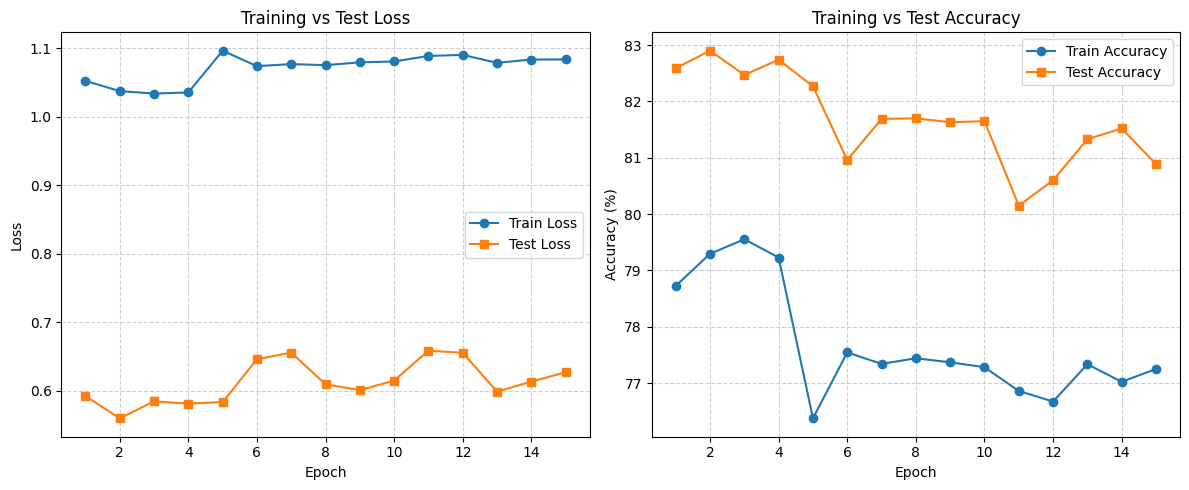

In [11]:
helper.plot_metrics(qat_metrics)

In [ ]:
model_qat.save_model('squeezenet_qatLR4new.pth')

In [ ]:
import torch

def convert_model_to_fixed_fp32(model, total_bits=8, int_bits=4):
    """
    Converts model weights to ap_fixed<total_bits,int_bits> values,
    but stores them in FP32 form (rounded and clipped).
    """
    frac_bits = total_bits - int_bits
    scale = 2 ** frac_bits

    # signed range for ap_fixed<8,4> → [-8, 7.9375]
    qmin = -2 ** (int_bits - 1)
    qmax = (2 ** (int_bits - 1)) - 1

    new_state = {}

    for name, param in model.state_dict().items():
        # Only quantize floating-point weights/biases
        if param.dtype.is_floating_point:
            w = param.cpu()

            # Step 1: integer quantization
            w_int = torch.clamp(
                torch.round(w * scale),
                qmin * scale,
                qmax * scale
            )

            # Step 2: store back as FP32 fixed-point
            w_fp32_fixed = (w_int / scale).float()

            new_state[name] = w_fp32_fixed
        else:
            # Non-FP params (e.g., buffers) stay unchanged
            new_state[name] = param

    return new_state

def load_fixed_model(model, path, device="cpu"):
    state = torch.load(path, map_location=device)
    model.load_state_dict(state)
    model.to(device)
    model.eval()
    print(f"Loaded fixed-point (fp32) converted weights from {path}")
    return model


In [21]:
fixed_state = convert_model_to_fixed_fp32(model_qat)

torch.save(fixed_state, "squeezenet_fixed8_4_fp32.pth")

In [16]:
model = SqueezeNetCIFAR10(num_classes=10)
load_fixed_model(model, "squeezenet_fixed8_4_fp32.pth", device)

Loaded fixed-point (fp32) converted weights from squeezenet_fixed8_4_fp32.pth


SqueezeNetCIFAR10(
  (conv1): Conv2dQuant(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (fire2): Fire(
    (conv1): Conv2dQuant(96, 16, kernel_size=(1, 1), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2dQuant(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv3): Conv2dQuant(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (fire3): Fire(
    (conv1): Conv2dQuant(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2dQuant(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv3): Conv2dQuant(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (fire4): Fire(
    (conv1): Conv2dQuant(128, 32, kernel_size=(1, 1), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2dQuant(32, 128, kernel_size=(1, 1), stride=(1, 1))
    (conv3): Conv2dQuant(32, 128, kernel_size=(3, 3), stride=(1, 1), paddi

In [29]:
model = SqueezeNetCIFAR10()
model.load_model('squeezenetLR4_14.pth')
fixed_state = convert_model_to_fixed_fp32(model_qat)
torch.save(fixed_state, "temp.pth")

load_fixed_model(model, "temp.pth", device)

Model loaded from squeezenetLR4_14.pth
Loaded fixed-point (fp32) converted weights from temp.pth


SqueezeNetCIFAR10(
  (conv1): Conv2dQuant(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (fire2): Fire(
    (conv1): Conv2dQuant(96, 16, kernel_size=(1, 1), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2dQuant(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv3): Conv2dQuant(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (fire3): Fire(
    (conv1): Conv2dQuant(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2dQuant(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv3): Conv2dQuant(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (fire4): Fire(
    (conv1): Conv2dQuant(128, 32, kernel_size=(1, 1), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2dQuant(32, 128, kernel_size=(1, 1), stride=(1, 1))
    (conv3): Conv2dQuant(32, 128, kernel_size=(3, 3), stride=(1, 1), paddi

In [9]:
def verify_quantized_model(model, test_loader, device, total_bits=8, int_bits=4):
    """
    Verify that using quantized weights gives expected accuracy.
    This simulates what will happen in HLS.
    """
    model.eval()
    frac_bits = total_bits - int_bits
    scale = 2 ** frac_bits
    qmin = -2 ** (int_bits - 1)
    qmax = (2 ** (int_bits - 1)) - 1
    
    # Create a copy with frozen quantized weights
    quantized_state = {}
    for name, param in model.state_dict().items():
        if param.dtype.is_floating_point and 'weight' in name:
            w = param.cpu()
            w_int = torch.clamp(torch.round(w * scale), qmin * scale, qmax * scale)
            quantized_state[name] = (w_int / scale).to(device)
        else:
            quantized_state[name] = param
    
    # Load quantized weights
    model.load_state_dict(quantized_state)
    model.to(device)
    
    # Evaluate
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, epoch=None, inference=True)  # Full quantization
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    accuracy = 100. * correct / total
    print(f"Accuracy with frozen quantized weights: {accuracy:.2f}%")
    return accuracy

In [10]:
model = SqueezeNetCIFAR10()
model.load_model('squeezenetLR4_10.pth')
verify_quantized_model(model,test_loader,device)

Model loaded from squeezenetLR4_10.pth
Accuracy with frozen quantized weights: 80.15%


80.15